In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from tqdm import tqdm
from joblib import Parallel, delayed

from skimage.draw import ellipse, polygon

import cv2

w_size = 128
train_num = 10


radius_min = 10
radius_max = 20

In [4]:
def next_pair():
    img_l = (np.random.sample((w_size, w_size, 3))*
             0.75).astype('float32')
    img_h = (np.random.sample((w_size, w_size, 3))*
             0.75 + 0.25).astype('float32')
    img = np.zeros((w_size, w_size, 4), dtype='float')

    p = np.random.sample() - 0.5
    r = np.random.sample()*(w_size-2*radius_max) + radius_max
    c = np.random.sample()*(w_size-2*radius_max) + radius_max
    r_radius = np.random.sample()*(radius_max-radius_min) + radius_min
    c_radius = np.random.sample()*(radius_max-radius_min) + radius_min
    rot = np.random.sample()*360
    rr, cc = ellipse(
        r, c, 
        r_radius, c_radius, 
        rotation=np.deg2rad(rot), 
        shape=img_l.shape
    )

    p1 = np.rint(np.random.sample()*
                 (w_size-2*radius_max) + radius_max)
    p2 = np.rint(np.random.sample()*
                 (w_size-2*radius_max) + radius_max)
    p3 = np.rint(np.random.sample()*
                 (2*radius_max - radius_min) + radius_min)
    p4 = np.rint(np.random.sample()*
                 (2*radius_max - radius_min) + radius_min)


    poly = np.array((
        (p1, p2),
        (p1, p2+p4),
        (p1+p3, p2+p4),
        (p1+p3, p2),
        (p1, p2),
    ))
    rr_p, cc_p = polygon(poly[:, 0], poly[:, 1], img_l.shape)

    in_sc_rr = list(set(rr) & set(rr_p))
    in_sc_cc = list(set(cc) & set(cc_p))

    if len(in_sc_rr) > 0 and len(in_sc_cc) > 0:
        if len(in_sc_rr) > 0:
            _delta_rr = np.max(in_sc_rr) - np.min(in_sc_rr) + 1
            if np.mean(rr_p) > np.mean(in_sc_rr):
                poly[:,0] += _delta_rr
            else:
                poly[:,0] -= _delta_rr
        
        if len(in_sc_cc) > 0:
            _delta_cc = np.max(in_sc_cc) - np.min(in_sc_cc) + 1
            if np.mean(cc_p) > np.mean(in_sc_cc):
                poly[:,1] += _delta_cc
            else:
                poly[:,1] -= _delta_cc
   
    rr_p, cc_p = polygon(poly[:, 0], poly[:, 1], img_l.shape)

    if p > 0:
        img[:,:,:3] = img_l.copy()
        img[rr, cc,:3] = img_h[rr, cc]
        img[rr_p, cc_p,:3] = img_h[rr_p, cc_p]
    else:
        img[:,:,:3] = img_h.copy()
        img[rr, cc,:3] = img_l[rr, cc]
        img[rr_p, cc_p,:3] = img_l[rr_p, cc_p]
        
    img[:,:,3] = 0.
    img[rr, cc,3] = 1.

    return img


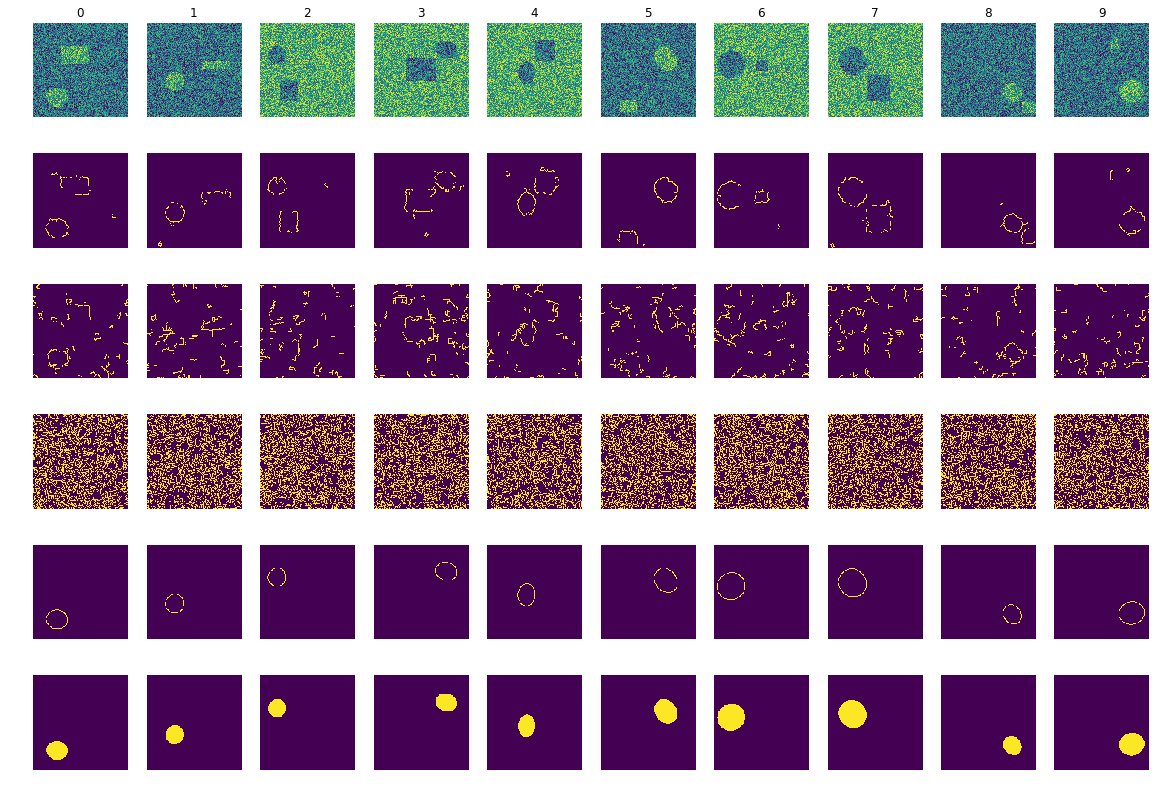

In [31]:
_txy = [next_pair() for idx in range(train_num)]
f_imgs = np.array(_txy)[:,:,:,:1].reshape(-1,w_size ,w_size ,1)
f_msks = np.array(_txy)[:,:,:,3:].reshape(-1,w_size ,w_size ,1)
t_img = np.zeros((w_size, w_size, 3), dtype='float')
t_msk = np.zeros((w_size, w_size, 1), dtype='float')
del(_txy)
    
fig, axes = plt.subplots(6, train_num, figsize=(20, 14))
for kk in range(train_num):
    axes[0,kk].set_title(kk)
    axes[0,kk].set_axis_off()
    axes[0,kk].imshow(f_imgs[kk].squeeze())
    
    axes[1,kk].set_axis_off()
    img = (f_imgs[kk]*255).astype("uint8")
    img = cv2.GaussianBlur(img,(7,7),0)
    axes[1,kk].imshow(cv2.Canny(img,100,200))

    axes[2,kk].set_axis_off()
    img = (f_imgs[kk]*255).astype("uint8")
    img = cv2.medianBlur(img,7)
    axes[2,kk].imshow(cv2.Canny(img,100,200))

    axes[3,kk].set_axis_off()
    img = (f_imgs[kk]*255).astype("uint8")
    img = cv2.bilateralFilter(img,9,75,75)
    axes[3,kk].imshow(cv2.Canny(img,100,200))
    
    axes[4,kk].set_axis_off()
    img = (f_msks[kk]*255).astype("uint8")
    axes[4,kk].imshow(cv2.Canny(img,100,200))
    axes[5,kk].set_axis_off()
    axes[5,kk].imshow(f_msks[kk].squeeze())

